In [1]:
%%capture
!pip install -q torch torchvision matplotlib pillow
import os
import json
import time
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
%%capture
! pip install segmentation_models_pytorch

In [4]:
import segmentation_models_pytorch as smp

In [3]:
# file ipython-input-24-931995489
class CocoSegmentationDataset(Dataset):
    def __init__(self, images_dir, annotation_file, class_ids, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.class_ids = class_ids
        self.num_classes = len(class_ids) + 1  # +1 for background

        with open(annotation_file, 'r') as f:
            data = json.load(f)

        self.imgs = {img['id']: img for img in data['images']}
        self.anns = {}
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)

        self.cat2idx = {cat_id: idx + 1 for idx, cat_id in enumerate(class_ids)}
        self.img_ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        image = Image.open(img_path).convert('RGB')
        mask = Image.new('L', (img_info['width'], img_info['height']), 0)

        anns = self.anns.get(img_id, [])
        draw = ImageDraw.Draw(mask)
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id not in self.cat2idx:
                continue
            class_idx = self.cat2idx[cat_id]
            # Check if segmentation is a list (polygon format)
            if isinstance(ann['segmentation'], list):
                for poly in ann['segmentation']:
                    # Check if the polygon has at least 3 points (6 coordinates)
                    if len(poly) >= 6:
                        try:
                            # Convert float coordinates to integers
                            points = [(int(poly[i]), int(poly[i+1])) for i in range(0, len(poly), 2)]
                            draw.polygon(points, fill=class_idx)
                        except ValueError:
                            # Handle cases where polygon coordinates might be non-numeric
                            print(f"Warning: Skipping invalid polygon data for image {img_id}, annotation {ann['id']}")
                            continue
            # Add handling for RLE format if necessary (not implemented here)
            # elif isinstance(ann['segmentation'], dict) and 'counts' in ann['segmentation']:
            #     # Decode RLE and draw mask
            #     pass # Add RLE decoding logic

        if self.transform:
            image = self.transform(image)
            _, h, w = image.shape
            # Resize the mask to match the transformed image size using Image.NEAREST
            mask = mask.resize((w, h), resample=Image.NEAREST)
        else:
            image = transforms.ToTensor()(image)
            # Ensure the mask is converted to a tensor if no transform is applied
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)


        # The mask should already be a tensor if no transform was applied,
        # but if a transform was applied (which returns a PIL Image for the mask after resize),
        # it needs conversion here. Also handles the case if mask was not converted in the else block.
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return image, mask

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(512 + 256, 256)
        self.dconv_up2 = DoubleConv(256 + 128, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        return self.conv_last(x)

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

In [7]:
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image = image_tensor.to(device).unsqueeze(0)
        output = model(image)
        probs = F.softmax(output, dim=1)
        mask = torch.argmax(probs, dim=1).squeeze(0)
    return mask.cpu().numpy()

In [8]:
def visualize_prediction(image_tensor, mask, class_labels, alpha=0.5):
    """
    Overlays predicted segmentation mask on the input image.

    Args:
        image_tensor (Tensor): (C, H, W)
        mask (ndarray): (H, W) predicted mask with class IDs
        class_labels (dict): class_id -> class_name
        alpha (float): transparency of overlay
    """
    # Convert image tensor to HWC format for display
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)  # assuming input was normalized

    # Define color map (make sure it has len(class_labels) colors)
    colormap = {
        1: (255, 0, 0),     # Red - cat
        2: (0, 255, 0),     # Green - dog
        3: (0, 0, 255),     # Blue - person
        4: (255, 255, 0),   # Yellow - cake
    }

    # Generate RGB mask
    mask_rgb = np.zeros_like(image)
    for class_id, color in colormap.items():
        mask_rgb[mask == class_id] = color

    # Blend original image with mask
    overlay = ((1 - alpha) * image + alpha * mask_rgb).astype(np.uint8)

    # Show the overlay
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Overlay of Prediction")
    plt.show()

In [9]:
# Define your dataset paths
train_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/data"
train_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/labels.json"
val_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/data"
val_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/labels.json"

# COCO IDs for selected classes
classes = [18, 15, 25, 41]  # person, cake, dog, cat
class_names = ["background", "person", "cake", "dog", "cat"]
num_classes = len(classes) + 1

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CocoSegmentationDataset(train_data_path, train_annotation, classes, transform)
val_dataset = CocoSegmentationDataset(val_data_path, val_annotation, classes, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#Unet
model_unet = UNet(num_classes).to(device)
unet_optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [11]:
# Model smp_unet
model_smp_unet = smp.Unet(
    encoder_name="resnet34",        # try resnet18/resnet50 for smaller/bigger models
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
)
model_smp_unet.to(device)
smp_unet_optimizer = torch.optim.Adam(model_smp_unet.parameters(), lr=1e-4)
model_smp_unet.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [12]:
# Train Unet model
train_losses_unet = []
val_losses_unet = []
print("Training UNET model")
epochs = 25
for epoch in range(1, epochs + 1):
    start = time.time()
    train_loss = train_one_epoch(model_unet, train_loader, criterion, unet_optimizer, device)
    val_loss = validate(model_unet, val_loader, criterion, device)
    train_losses_unet.append(train_loss)
    val_losses_unet.append(val_loss)
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time()-start:.1f}s")
torch.save(model_unet.state_dict(), "/content/drive/Othercomputers/My Mac/Image Segmentation/unet_model.pth")
print("Model saved as smp_unet_model.pth")

Training UNET model
Epoch 1/25 | Train Loss: 1.1491 | Val Loss: 1.0036 | Time: 114.5s
Epoch 2/25 | Train Loss: 0.8507 | Val Loss: 0.8499 | Time: 8.8s
Epoch 3/25 | Train Loss: 0.7107 | Val Loss: 0.7823 | Time: 8.8s
Epoch 4/25 | Train Loss: 0.6051 | Val Loss: 0.6633 | Time: 8.8s
Epoch 5/25 | Train Loss: 0.5144 | Val Loss: 0.5956 | Time: 8.6s
Epoch 6/25 | Train Loss: 0.4501 | Val Loss: 0.5762 | Time: 8.9s
Epoch 7/25 | Train Loss: 0.4034 | Val Loss: 0.5332 | Time: 8.8s
Epoch 8/25 | Train Loss: 0.3692 | Val Loss: 0.5119 | Time: 8.8s
Epoch 9/25 | Train Loss: 0.3414 | Val Loss: 0.5077 | Time: 8.7s
Epoch 10/25 | Train Loss: 0.3202 | Val Loss: 0.4872 | Time: 8.8s
Epoch 11/25 | Train Loss: 0.3067 | Val Loss: 0.4974 | Time: 8.8s
Epoch 12/25 | Train Loss: 0.2893 | Val Loss: 0.4862 | Time: 8.8s
Epoch 13/25 | Train Loss: 0.2803 | Val Loss: 0.4915 | Time: 8.7s
Epoch 14/25 | Train Loss: 0.2720 | Val Loss: 0.4931 | Time: 8.8s
Epoch 15/25 | Train Loss: 0.2662 | Val Loss: 0.4988 | Time: 8.8s
Epoch 16/25 

In [ ]:
#Load the model
model_unet.load_state_dict(torch.load("/content/drive/Othercomputers/My Mac/Image Segmentation/unet_model.pth"))

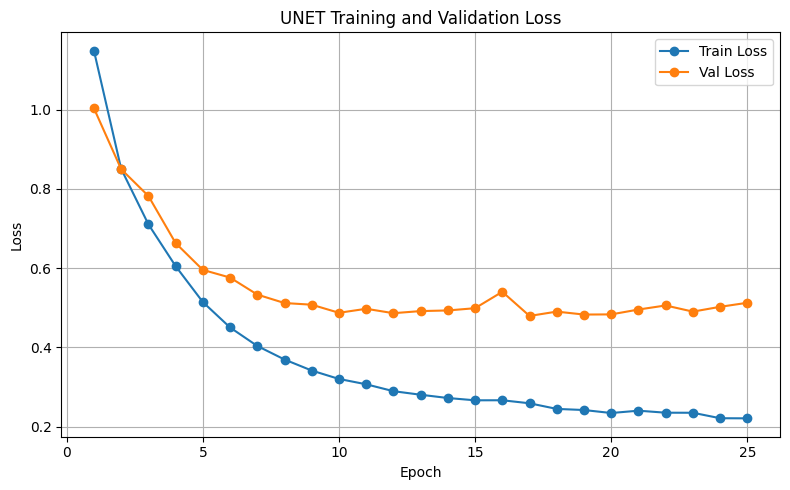

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses_unet, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses_unet, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("UNET Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Train Smp UNET model
train_losses_unet_smp = []
val_losses_unet_smp = []
print("Training smp UNET model")
epochs = 25
for epoch in range(1, epochs + 1):
    start = time.time()
    train_loss = train_one_epoch(model_smp_unet, train_loader, criterion, smp_unet_optimizer, device)
    val_loss = validate(model_smp_unet, val_loader, criterion, device)
    train_losses_unet_smp.append(train_loss)
    val_losses_unet_smp.append(val_loss)
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time()-start:.1f}s")
# Save the model
torch.save(model_smp_unet.state_dict(), "/content/drive/Othercomputers/My Mac/Image Segmentation/smp_unet_model.pth")
print("Model saved as smp_unet_model.pth")

Training smp UNET model
Epoch 1/25 | Train Loss: 0.2118 | Val Loss: 0.4261 | Time: 8.1s
Epoch 2/25 | Train Loss: 0.1752 | Val Loss: 0.3805 | Time: 8.2s
Epoch 3/25 | Train Loss: 0.1504 | Val Loss: 0.3786 | Time: 8.1s
Epoch 4/25 | Train Loss: 0.1266 | Val Loss: 0.3884 | Time: 8.3s
Epoch 5/25 | Train Loss: 0.1161 | Val Loss: 0.3999 | Time: 8.2s
Epoch 6/25 | Train Loss: 0.1102 | Val Loss: 0.3878 | Time: 8.1s
Epoch 7/25 | Train Loss: 0.0966 | Val Loss: 0.3898 | Time: 8.2s
Epoch 8/25 | Train Loss: 0.0850 | Val Loss: 0.4224 | Time: 8.2s
Epoch 9/25 | Train Loss: 0.0841 | Val Loss: 0.3984 | Time: 8.1s
Epoch 10/25 | Train Loss: 0.0933 | Val Loss: 0.4244 | Time: 8.2s
Epoch 11/25 | Train Loss: 0.0990 | Val Loss: 0.4345 | Time: 8.2s
Epoch 12/25 | Train Loss: 0.0764 | Val Loss: 0.4426 | Time: 8.2s
Epoch 13/25 | Train Loss: 0.0756 | Val Loss: 0.4253 | Time: 8.2s
Epoch 14/25 | Train Loss: 0.0664 | Val Loss: 0.4325 | Time: 8.3s
Epoch 15/25 | Train Loss: 0.0605 | Val Loss: 0.4495 | Time: 8.1s
Epoch 16/2

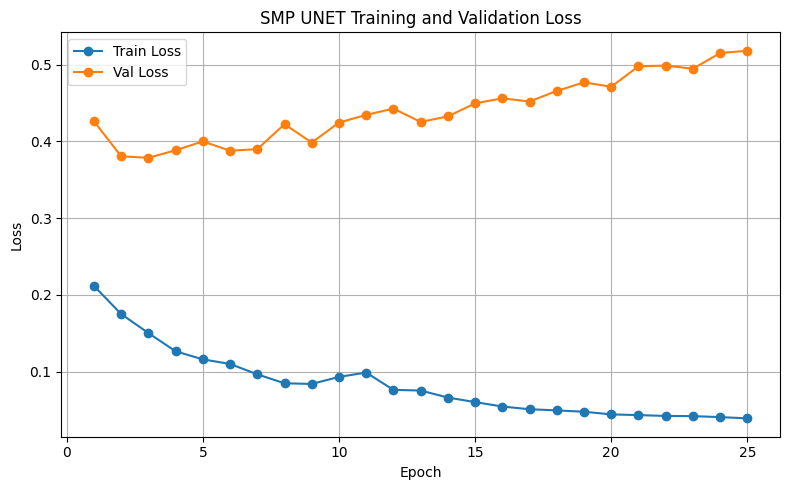

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses_unet_smp, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses_unet_smp, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SMP UNET Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

UNET Prediction


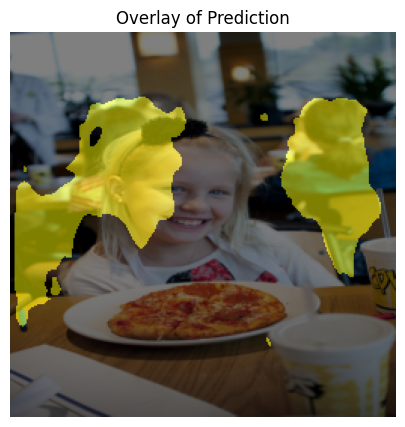

In [18]:
# UNET Prediction
print("UNET Prediction")
sample_img, _ = val_dataset[150]
pred_mask = predict(model_unet, sample_img, device)
visualize_prediction(sample_img, pred_mask, class_names)

smp UNET Prediction


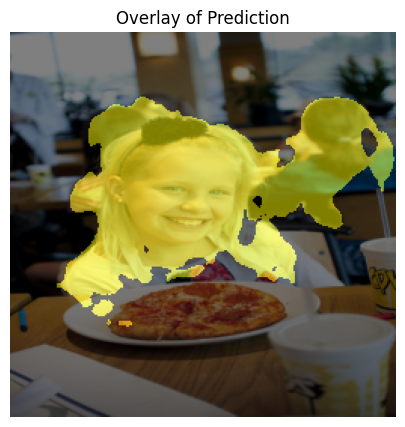

In [19]:
# Smp UNET Prediction
print("smp UNET Prediction")
sample_img, _ = val_dataset[150]
pred_mask = predict(model_smp_unet, sample_img, device)
visualize_prediction(sample_img, pred_mask, class_names)